In [1]:
# This is the third attempt at training a NN. I am doing sequence padding
# again, but truncating to as low a value as possible to make training
# faster and avoid memory issues (I've been having crashes on the current)
# feature set

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.layers.recurrent import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
np.random.seed(42)

In [3]:
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

# a function for writing predictions in the required format
def write_predictions(predictions, ids, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        # write header
        f.write("Id,Prediction\n")
        for i, history_id in enumerate(ids):
            f.write("%s,%d\n" % (history_id, predictions[i]))

def classes_to_Y(classes):
    output = []
    for cls in classes:
        output.append(malware_classes.index(cls))
    return np.array(output)

In [4]:
# load training classes
classes = np.load("../data/features/train_classes.npy")

In [5]:
# load sparse matrix of training data
full_features = np.load("../data/features/100_cutoff_alphabet_19679_word_to_intseq.npy")
# The way masking works, 0 must be maintained as a "ignore this" symbol,
# so I have to increase the index by 1 to free the zero index.
for i in xrange(len(full_features)):
    full_features[i] +=1 #Add 1 to each of the arrays in the array
    
print full_features[0]



[  734   566     4     5  1150   558   740     4   785  5849    11     3
     1   547    12    40   804  2049   946     1   947     1   811   113
   805     5   803    68  3872   808  1827  2759   807  1591   809  1174
   806   654  1590  1592   478   604  5653   495   844    11     3     1
   547    10     4     6  1222    13  4798     7  1983    12    40    14
    11     3     2     9   680     8    10     4     6   700    13   702
     7   698    12   696    14    11     3     2     9   134     8    10
     4     6   309    13   310     7   308    12   303    14    11     3
     2   694   709     2   678   725     5   697   723   727    10     4
     6   729    13   730     7   728    12    40    14    11     3     2
     9   798     8    10     4     6   818    13   817     7   792    12
   802    14    11     3     2     9   216     8    10     4     6   476
    13   477     7   475    12   474    14    11     3     2     9   774
     8    10     4     6   779    13   780     7   

In [ ]:
# The way masking works, 0 must be maintained as a "ignore this" symbol,
# so I have to increase the index by 1 to free the zero index.
for i in xrange(len(full_features)):
    full_features[i] +=1 #Add 1 to each of the arrays in the array
    
print full_features[0]

In [6]:
maxlengths = [len(x) for x in full_features]

(0, 200000)

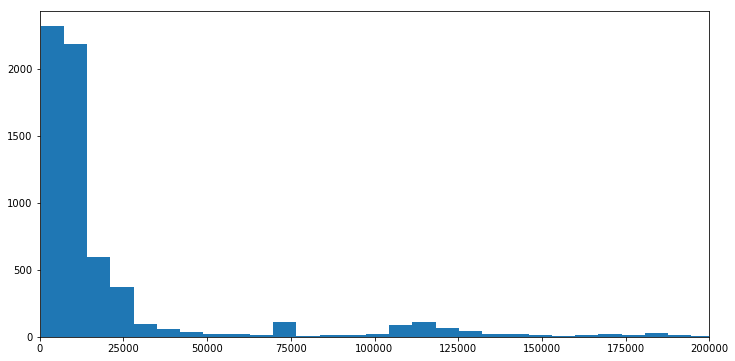

In [8]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.hist(maxlengths, bins=1000);
ax.set_xlim(0,200000)

In [6]:
# Truncateto the first 35000 words
padded = pad_sequences(full_features, maxlen=1000, truncating='post')

print padded.shape # Should be a num_samples by num_features np array


(6810, 1000)


In [7]:
# If this all looks good, save the array for later

np.save("../data/features/100_cutoff_alphabet_19679_padded_len1.npy", padded)

In [8]:
padded = 0

In [9]:
# In future, can load just with this line 
full_features = np.load("../data/features/100_cutoff_alphabet_19679_padded_len1.npy")

In [10]:
# pull out training examples
X = full_features[:classes.shape[0],:]

X_test = full_features[classes.shape[0]:,:]
print X_test.shape

Y = classes_to_Y(classes)

Y_hot = np.zeros((classes.shape[0], 16))
for i, clazz in enumerate(Y):
    Y_hot[i,clazz] = 1

print Y_hot

(3724, 1000)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [11]:
# Just to check that worked ok.
print classes[21]
print Y[21]
print Y_hot[21]
print len(malware_classes)

None
8
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
15


In [12]:
# Now randomly select 100 samples to hold out
rand_index = np.random.permutation(np.arange(classes.shape[0]))

X_train = X[rand_index[100:]]
Y_train = Y_hot[rand_index[100:]]
X_validate = X[rand_index[:100]]
Y_validate = Y_hot[rand_index[:100]]


print X_train.shape

print Y_train.shape

print X_validate.shape

print Y_validate.shape
                                   

(2986, 1000)
(2986, 16)
(100, 1000)
(100, 16)


In [13]:
# Clobbering to save memory
padding = 0
full_features = 0
classes= 0
X = 0
Y_hot = 0
Y =0

In [14]:
# The vocabulary size is 2 + the maximum integer index. 
# To allow for padding (wout padding would be 1)
vocab_size = 19681

# Length of the dense embedding one for each int in the sequence
embedding_length = 256 # arbitrary

# Should be able to vary batch size with mask
batch_size = 150
model = Sequential()

# Collapse the large input dimension into a 256 dimensional
# dense embedding
model.add(
    Embedding(vocab_size, embedding_length, mask_zero=True)
)

# Could add a Dropout layer next but will avoid for now
model.add(Bidirectional(
    LSTM(100, return_sequences=True)
))# Arbitrary output size. TODO make this stateful

# Why not 2!
model.add(LSTM(42)) # Arbitrary again

model.add(Dense(200, activation="sigmoid"))
model.add(Dense(16, activation="softmax"))

In [15]:
model.compile(loss='categorical_crossentropy',
             optimizer="adam",
             metrics=["accuracy"])

In [16]:
from keras.callbacks import ProgbarLogger, History, LambdaCallback

In [17]:
import psutil
from __future__ import print_function
summarize = lambda *__: print([psutil.virtual_memory(),psutil.cpu_percent(percpu=True)])

In [18]:
callbacks = [
    ProgbarLogger(), 
    History(),
    LambdaCallback(
        on_batch_begin=summarize, 
        on_batch_end=summarize, 
        on_epoch_begin=summarize
    )]

model.fit(
    X_train, Y_train, batch_size=batch_size,
    nb_epoch=5, verbose=1, callbacks=callbacks, 
    validation_data=(X_validate, Y_validate)
    )

Train on 2986 samples, validate on 100 samples
Epoch 1/5
[svmem(total=270846246912, available=236968771584, percent=12.5, used=24198422528, free=121542279168, active=38561837056, inactive=103220097024, buffers=454303744, cached=124651241472, shared=8814125056), [100.0, 77.1, 0.1, 0.1, 100.0, 57.1, 0.1, 0.0, 0.1, 0.1, 0.0, 0.2, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.7, 0.4, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Epoch 1/5
[svmem(total=270846246912, available=236968771584, percent=12.5, used=24198422528, free=121542279168, active=38561837056, inactive=103220097024, buffers=454303744, cached=124651241472, shared=8814125056), [100.0, 0.0, 0.0, 0.0, 100.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
print "ok"

In [19]:
predictions = model.predict(X_test)
np.save("../predictions/tiny_seq_LSTM1.npy", predictions)
class_preds = model.predict_classes(X_test)
class_prob = model.predict_proba(X_test)
np.save("../predictions/tiny_seq_class_LSTM1.npy", class_preds)
np.save("../predictions/tiny_seq_class_proba_LSTM1.npy", class_proba)

3724/3724 [==============================] - 363s     

NameError: name 'class_proba' is not defined